<a href="https://colab.research.google.com/github/MuhammadNurilHuda/DeepFake-Detection/blob/main/Deepfake_Detection_MTCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEPFAKE DETECTION

In [ ]:
# import os
# import zipfile

# local_zip = '/content/drive/MyDrive/Kaggle/deepfake-detection-challenge.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/drive/MyDrive/Kaggle')
# zip_ref.close()

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Kaggle/train_sample_videos/'

BATCH_SIZE = 1
SCALE = 0.25
N_FRAMES = None

## Install Dependencies

In [ ]:
# Install facenet-pytorch
!pip install /content/drive/MyDrive/Kaggle/facenet_pytorch_vggface2/facenet_pytorch-2.0.0-py3-none-any.whl

Processing ./drive/MyDrive/Kaggle/facenet_pytorch_vggface2/facenet_pytorch-2.0.0-py3-none-any.whl


In [ ]:
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p $torch_home/checkpoints/
!cp /content/drive/MyDrive/Kaggle/facenet_pytorch_vggface2/20180402-114759-vggface2-logits.pth $torch_home/checkpoints/vggface2_DG3kwML46X.pt
!cp /content/drive/MyDrive/Kaggle/facenet_pytorch_vggface2/20180402-114759-vggface2-features.pth $torch_home/checkpoints/vggface2_G5aNV2VSMn.pt

## Import Library

In [ ]:
import os
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1

# Library Hyper--parameters
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


## Define class

In [ ]:
class DetectionPipeline:
    """Pipeline class untuk deteksi wajah di setiap frame."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total frames yang di load. default: {None}, semua frame akan diload
            batch_size {int} -- Batch size untuk MTCNN face detector. (default: {32})
            resize {float} -- kurang dari 1 akan downsampling. Lebih dari 1 akan upsampling. 
            (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frame MP4 video dan deteksi wajah.

        Arguments:
            filename {str} -- Path video.
        """
        # Video reader dan panjang video
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # mengambil 'n_frames' bingkai dengan jarak yang sama untuk sampel
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop per frame
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame 
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # Deteksi wajah dan reset frame list ketika batch full
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces

## Define Helper Function

In [ ]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
def process_faces(faces, feature_extractor):
    # Filter frame tanpa wajah
    faces = [f for f in faces if f is not None]
    if len(faces) == 0:
        return None
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors menggunakan pretrained model
    embeddings = feature_extractor(faces)

    # Hitung centroid untuk video dan jarak setiap vektor fitur wajah dari centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

## Data Preparation

In [ ]:
# Load Face Detector MTCNN
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

In [ ]:
# Load facial recognition RESNET
feature_extractor = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [ ]:
# Face detection pipeline
detection_pipeline = DetectionPipeline(detector=face_detector, n_frames=N_FRAMES, batch_size=BATCH_SIZE, resize=SCALE)

In [ ]:
all_train_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))
metadata_path = TRAIN_DIR + 'metadata.json'

with open(metadata_path, 'r') as f:
  metadata = json.load(f)

In [ ]:
df = pd.DataFrame(columns=['filename', 'distance', 'label'])

with torch.no_grad():
  for path in tqdm(all_train_videos):
    file_name = path.split('/')[-1]

    # Deteksi semua wajah di dalam video
    faces = detection_pipeline(path)

    # Menghitung distance
    distances = process_faces(faces, feature_extractor)
    if distances is None:
      continue

    for distance in distances:
      row = [file_name, distance, 1 if metadata[file_name]['label'] == 'FAKE' else 0]

      # Menambahkan baris baru kedalam dataframe
      df.loc[len(df)] = row

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
df.head()

,filename,distance,label
0,aagfhgtpmv.mp4,0.582117,1
1,aagfhgtpmv.mp4,0.585001,1
2,aagfhgtpmv.mp4,0.615604,1
3,aagfhgtpmv.mp4,0.624292,1
4,aagfhgtpmv.mp4,0.629783,1


In [ ]:
df.to_csv('/content/drive/MyDrive/Kaggle/train.csv', index=False)

## Hyper-parameters

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Kaggle/train.csv'
SAVE_PATH = '/content/drive/MyDrive/Kaggle/deepfake_model.pth'

TEST_SIZE = 0.3
RANDOM_STATE = 128
EPOCHS = 200
BATCH_SIZE = 32
LR = 0.00001

## Define Class

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, D_in=1, D_out=1):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(D_in, D_out)

  def forward(self, x):
    y_pred = self.linear(x)
    return y_pred

  def predict(self, x):
    result = self.forward(x)

    return torch.sigmoid(result)

## Helper Function

In [ ]:
def shuffle_data(X, y):
  assert len(X) == len(y)

  p = np.random.permutation(len(X))

  return X[p], y[p]

## Mengambil data

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,filename,distance,label
0,aagfhgtpmv.mp4,0.582117,0
1,aagfhgtpmv.mp4,0.585001,0
2,aagfhgtpmv.mp4,0.615604,0
3,aagfhgtpmv.mp4,0.624292,0
4,aagfhgtpmv.mp4,0.629783,0


In [ ]:
# label_count = train_df.groupby('label').count()['filename']
# print(label_count)

# # pos_weight value untuk mengatasi imbalanced dataset.
# # referensi : https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
# pos_weight = torch.ones([1]) * label_count[0]/label_count[1]
# print('pos_weight:', pos_weight)

In [ ]:
X = train_df['distance'].to_numpy()
y = train_df['label'].to_numpy()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [ ]:
X_train = torch.tensor(X_train).to(device).unsqueeze(dim=1).float()
X_val = torch.tensor(X_val).to(device).unsqueeze(dim=1).float()
y_train = torch.tensor(y_train).to(device).unsqueeze(dim=1).float()
y_val = torch.tensor(y_val).to(device).unsqueeze(dim=1).float()

## Train Model Menggunakan Logistic Regression

In [ ]:
classifier = LogisticRegression()
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(classifier.parameters(), lr=LR)

n_batches = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
losses = np.zeros(EPOCHS)
val_losses = np.zeros(EPOCHS)
best_val_loss = 1e7

for e in tqdm(range(EPOCHS)):
  batch_losses = np.zeros(n_batches)
  pbar = tqdm(range(n_batches))
  pbar.desc = f'Epoch {e+1}'
  classifier.train()
  
  # Shuffle training data
  X_train, y_train = shuffle_data(X_train, y_train)

  for i in pbar:
    # Get batch.
    X_batch = X_train[i*BATCH_SIZE:min(len(X_train), (i+1)*BATCH_SIZE)]
    y_batch = y_train[i*BATCH_SIZE:min(len(y_train), (i+1)*BATCH_SIZE)]

    # Make prediction.
    y_pred = classifier(X_batch)

    # Compute loss.
    loss = criterion(y_pred, y_batch)
    batch_losses[i] = loss

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  # Compute batch loss (average)
  losses[e] = batch_losses.mean()

  # Compute val loss
  classifier.eval()
  y_val_pred = classifier(X_val)
  val_losses[e] = criterion(y_val_pred, y_val)
  
  # Save model based on the best (lowest) val loss.
  if val_losses[e] < best_val_loss:
    print('Found a better checkpoint!')
    torch.save(classifier.state_dict(), SAVE_PATH)
    best_val_loss = val_losses[e]
      
  
  # Display some information in progress-bar.
  pbar.set_postfix({
      'loss': losses[e],
      'val_loss': val_losses[e]})

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2787 [00:00<?, ?it/s]

Found a better checkpoint!


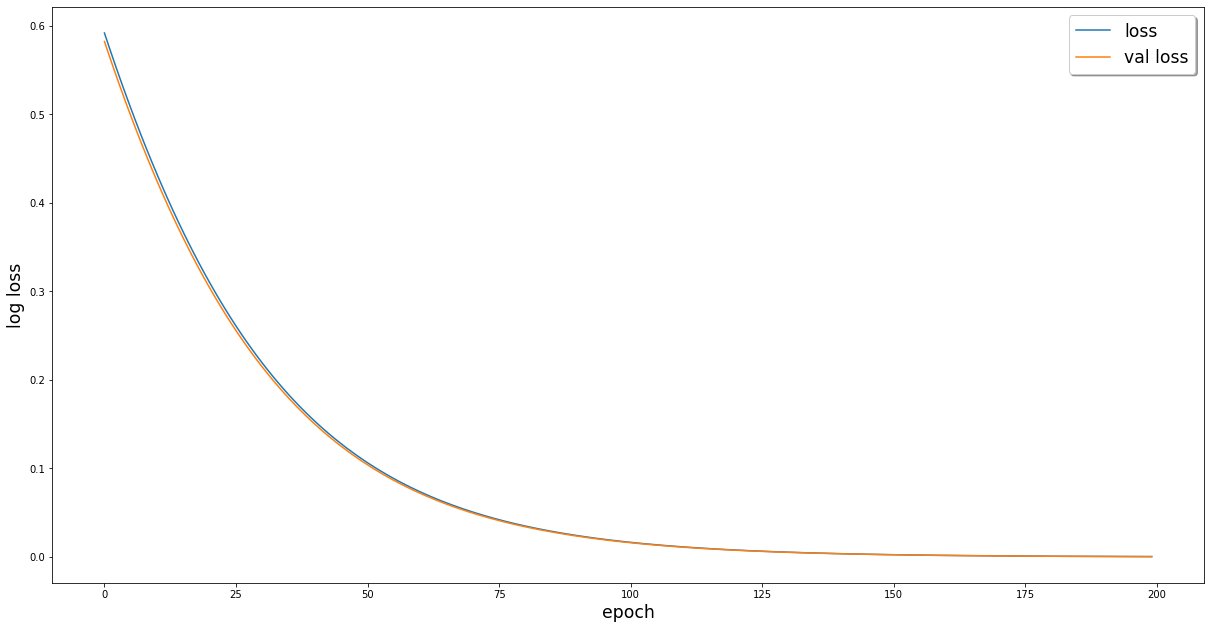

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(np.arange(EPOCHS), losses)
ax.plot(np.arange(EPOCHS), val_losses)
ax.set_xlabel('epoch', fontsize='xx-large')
ax.set_ylabel('log loss', fontsize='xx-large')
ax.legend(
    ['loss', 'val loss'],
    loc='upper right',
    fontsize='xx-large',
    shadow=True
)
plt.show()

In [ ]:
without_weight_criterion = nn.BCELoss(reduction='mean')

classifier.eval()
with torch.no_grad():
  y_val_pred = classifier.predict(X_val)
  val_loss = without_weight_criterion(y_val_pred, y_val)

print('val loss:', val_loss.detach().numpy())

val loss: 0.00041057752


[]

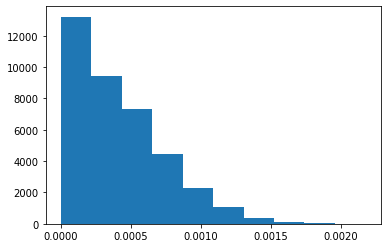

In [ ]:
plt.hist(y_val_pred.squeeze(dim=-1).detach())
plt.plot()